In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [0]:
!kaggle datasets download -d arnaud58/horse2zebra

 95% 106M/111M [00:01<00:00, 79.9MB/s] 
100% 111M/111M [00:01<00:00, 85.4MB/s]


In [0]:
!git clone https://www.github.com/keras-team/keras-contrib.git

%cd keras-contrib


Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634
Receiving objects: 100% (3634/3634), 861.24 KiB | 708.00 KiB/s, done.
Resolving deltas: 100% (2330/2330), done.
/content/keras-contrib


In [0]:
!python setup.py install


running install
running bdist_egg
running egg_info
creating keras_contrib.egg-info
writing keras_contrib.egg-info/PKG-INFO
writing dependency_links to keras_contrib.egg-info/dependency_links.txt
writing requirements to keras_contrib.egg-info/requires.txt
writing top-level names to keras_contrib.egg-info/top_level.txt
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
writing manifest file 'keras_contrib.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/keras_contrib
copying keras_contrib/__init__.py -> build/lib/keras_contrib
creating build/lib/keras_contrib/utils
copying keras_contrib/utils/conv_utils.py -> build/lib/keras_contrib/utils
copying keras_contrib/utils/save_load_utils.py -> build/lib/keras_contrib/utils
copying keras_contrib/utils/__init__.py -> build/lib/keras_contrib/utils
copying keras_contrib/utils/test_utils.py -> build/lib/keras_contrib/utils


In [0]:
sys.path.append('/content/keras-contrib')

In [0]:
!unzip '/content/drive/My Drive/Kaggle/horse2zebra.zip' 


  inflating: horse2zebra/trainA/n02381460_1147.jpg  
  inflating: horse2zebra/trainA/n02381460_1155.jpg  
  inflating: horse2zebra/trainA/n02381460_1158.jpg  
  inflating: horse2zebra/trainA/n02381460_1159.jpg  
  inflating: horse2zebra/trainA/n02381460_1168.jpg  
  inflating: horse2zebra/trainA/n02381460_117.jpg  
  inflating: horse2zebra/trainA/n02381460_1182.jpg  
  inflating: horse2zebra/trainA/n02381460_1184.jpg  
  inflating: horse2zebra/trainA/n02381460_1191.jpg  
  inflating: horse2zebra/trainA/n02381460_1194.jpg  
  inflating: horse2zebra/trainA/n02381460_1197.jpg  
  inflating: horse2zebra/trainA/n02381460_1204.jpg  
  inflating: horse2zebra/trainA/n02381460_1208.jpg  
  inflating: horse2zebra/trainA/n02381460_1212.jpg  
  inflating: horse2zebra/trainA/n02381460_1216.jpg  
  inflating: horse2zebra/trainA/n02381460_122.jpg  
  inflating: horse2zebra/trainA/n02381460_1226.jpg  
  inflating: horse2zebra/trainA/n02381460_1227.jpg  
  inflating: horse2zebra/trainA/n02381460_1232.

# Load and view the dataset

In [0]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from numpy import load
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint

In [0]:
#load all images in the directory into memory
def load_images(path,size=(256,256)):
  data_list=list()
  for filename in listdir(path):
    #load and resize the image
    pixels=load_img(path+filename,target_size=size)
    #convert to numpy array
    pixels=img_to_array(pixels)
    #store
    data_list.append(pixels)
  return asarray(data_list)

path='/content/drive/My Drive/Kaggle/horse2zebra/'
#load dataset A
dataA1=load_images(path+'trainA/')
dataA2=load_images(path+'testA/')
dataA=vstack((dataA1,dataA2))
print('Loaded dataA: ', dataA.shape)
#load dataset B
dataB1=load_images(path+'trainB/')
dataB2=load_images(path+'testB/')
dataB=vstack((dataB1,dataB2))
print('Loaded dataB: ', dataB.shape)
#save as compressed numpy array
filename='horses2zebra_256.npz'
savez_compressed(filename,dataA,dataB)

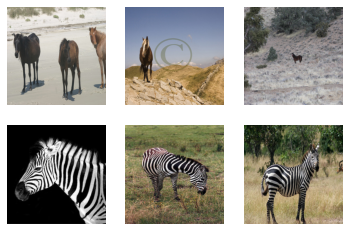

In [0]:
n_samples=3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

# CycleGAN model

In [4]:
import tensorflow as tf
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization


Using TensorFlow backend.


In [0]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import  Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from matplotlib import pyplot
from keras.models import load_model


In [0]:
#define the discriminator model
def define_discriminator(image_shape):
  #weight initialization
  init=RandomNormal(stddev=0.02)
  #source image input
  in_image=Input(shape=image_shape)
  # C64
  d=Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(in_image)
  d=LeakyReLU(alpha=0.2)(d)
  # C128
  d=Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)
  # C256
  d=Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)
  # C512
  d=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)
  # second last output layer
  d=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d)
  d=InstanceNormalization(axis=-1)(d)
  d=LeakyReLU(alpha=0.2)(d)
  #patch output
  patch_out=Conv2D(1,(4,4),padding='same',kernel_initializer=init)(d)
  #define model
  model=Model(in_image,patch_out)
  #compile model
  model.compile(loss='mse',optimizer=Adam(lr=0.0002,beta_1=0.5),loss_weights=[0.5])
  return model

In [0]:
#generate a resnet block
def resnet_block(n_filters,input_layer):
  #weight initialization
  init=RandomNormal(stddev=0.02)
  #first layer convolutional layer
  g=Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)
  #second convolutional layer
  g=Conv2D(n_filters,(3,3),padding='same',kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  #concatenate merge channel wise with input layer
  g=Concatenate()([g,input_layer])
  return g



In [0]:
#define the standalone generator model
def define_generator(image_shape,n_resnet=9):
  # weight initialization
  init=RandomNormal(stddev=0.02)
  # image input
  in_image=Input(shape=image_shape)
  # c7s1-64
  g=Conv2D(64,(7,7),padding='same',kernel_initializer=init)(in_image)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)
  # d128
  g=Conv2D(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)
  # d256
  g=Conv2D(256,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)
  # R256
  for _ in range(n_resnet):
    g=resnet_block(256,g)
  # u128
  g=Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)
  # u64
  g=Conv2DTranspose(64,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  g=Activation('relu')(g)
  # c7s1-3
  g=Conv2D(3,(7,7),padding='same',kernel_initializer=init)(g)
  g=InstanceNormalization(axis=-1)(g)
  out_image=Activation('tanh')(g)
  #define model
  model=Model(in_image,out_image)
  return model

In [0]:
#define a composite model for updating generators by adversial and cycle losss
def define_composite_model(g_model_1,d_model,g_model_2,image_shape):
  #ensure model we are updating is trainable
  g_model_1.trainable=True
  #discriminator shouldn't train
  d_model.trainable=False
  #other generator model as non trainable
  g_model_2.trainable=False
  #discriminator element
  input_gen=Input(shape=image_shape)
  gen1_out=g_model_1(input_gen)
  output_d=d_model(gen1_out)
  #identity element
  input_id=Input(shape=image_shape)
  output_id=g_model_1(input_id)
  #forward cycle
  output_f=g_model_2(gen1_out)
  #backward cycle
  gen2_out=g_model_2(input_id)
  output_b=g_model_1(gen2_out)
  #define model graph
  model=Model([input_gen,input_id],[output_d,output_id,output_f,output_b])
  #compile model with weighting of L1 and L2 loss
  model.compile(loss=['mse','mae','mae','mae'],loss_weights=[1,5,10,10],optimizer=Adam(lr=0.0002,beta_1=0.5))
  return model


# Prepare training images

In [0]:
# load and prepare training images
def load_real_samples(filename):
  # load the dataset
  data = load(filename)
  # unpack arrays
  X1, X2 = data['arr_0'], data['arr_1']
  # scale from [0,255] to [-1,1]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]  

In [0]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return X, y

In [0]:
#generate a batch of images,returns images and targets
def generate_fake_samples(g_model,dataset,patch_shape):
  #generate fake instance
  X=g_model.predict(dataset)
  #create 'fake' class labels (0)
  y=zeros((len(X),patch_shape,patch_shape,1))
  return X,y

In [0]:
#save the generator models to file
def save_models(step,g_model_A2B,g_model_B2A):
  #save the first generator model
  filename1='g_model_A2B_%06d.h5' % (step+1)
  g_model_A2B.save(filename1)
  #save the second generator model
  filename2='g_model_B2A_%06d.h5' % (step+1)
  g_model_B2A.save(filename2)

In [0]:
#generate sample and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
  # select a sample of input images
  X_in, _ = generate_real_samples(trainX, n_samples, 0)
  # generate translated images
  X_out, _ = generate_fake_samples(g_model, X_in, 0)
  # scale all pixels from [-1,1] to [0,1]
  X_in = (X_in + 1) / 2.0
  X_out = (X_out + 1) / 2.0
  # plot real images
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(X_in[i])
  # plot translated image
  for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(X_out[i])
  # save plot to file
  filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
  plt.savefig(filename1)
  plt.close()

In [0]:
# update image pool for fake images
def update_image_pool(pool,images,max_size=50):
  selected=list()
  for image in images:
    if len(pool) < max_size:
      #stock the pool
      pool.append(image)
      selected.append(image)
    elif random() < 0.5:
      #use image,but dont add it to the pool
      selected.append(image)
    else:
      #replace on existing image and use replaced image
      ix=randint(0,len(pool))
      selected.append(pool[ix])
      pool[ix]=image
  return asarray(selected)

# Train the CycleGAN model

In [0]:
#train the cycleGAN models
def train(d_model_A, d_model_B, g_model_A2B, g_model_B2A, c_model_A2B, c_model_B2A, dataset):
  #define properties of the training run
  n_epochs,n_batch =100,1
  #determine the output square shape of the discriminator
  n_patch= d_model_A.output_shape[1]
  #unpack dataset
  trainA,trainB=dataset
  #prepare image pool for fakes
  poolA,poolB=list(),list()
  #calculate no.of batches per trainig epoch
  bat_per_epo=int(len(trainA)/n_batch)
  #calculate no.of training iterations
  n_steps= bat_per_epo * n_epochs
  #enumerate epochs
  for i in range(n_steps):
    #select a batch of real samples
    X_realA,y_realA=generate_real_samples(trainA,n_batch,n_patch)
    X_realB,y_realB=generate_real_samples(trainB,n_batch,n_patch)
    #generate a batch of fake sampes
    X_fakeA,y_fakeA=generate_fake_samples(g_model_B2A,X_realB,n_patch)
    X_fakeB,y_fakeB=generate_fake_samples(g_model_A2B,X_realA,n_patch)
    #update fakes from pool
    X_fakeA=update_image_pool(poolA,X_fakeA)
    X_fakeB=update_image_pool(poolB,X_fakeB)
    #update generator B->A via adversial and cycle loss
    g_loss2,_,_,_,_=c_model_B2A.train_on_batch([X_realB,X_realA],[y_realA,X_realA,X_realB,X_realA])
    #update discriminator for A -> [real/fake]
    dA_loss1=d_model_A.train_on_batch(X_realA,y_realA)
    dA_loss2=d_model_A.train_on_batch(X_fakeA,y_fakeA)
    #update generator B->A via adversial and cycle loss
    g_loss1,_,_,_,_=c_model_A2B.train_on_batch([X_realA,X_realB],[y_realB,X_realB,X_realA,X_realB])
    #update discriminator for B -> [real/fake]
    dB_loss1=d_model_B.train_on_batch(X_realB,y_realB)
    dB_loss2=d_model_B.train_on_batch(X_fakeB,y_fakeB)
    #summarize performance
    
    print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
    if(i+1)%(bat_per_epo)==0:
      #save the models
      save_models(i,g_model_A2B,g_model_B2A)

In [0]:
#load image data
dataset=load_real_samples('/content/drive/My Drive/Kaggle/horses2zebra_256.npz')
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

In [0]:
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)

In [0]:
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

In [0]:
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [0]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, dA[0.838,0.702] dB[1.525,0.608] g[21.102,18.831]
>2, dA[1.272,0.894] dB[0.830,0.911] g[17.131,16.631]
>3, dA[3.136,0.715] dB[1.191,1.031] g[18.198,18.592]
>4, dA[3.277,0.761] dB[1.022,0.677] g[19.324,19.464]
>5, dA[9.308,0.914] dB[0.968,0.745] g[15.707,16.991]
>6, dA[1.507,1.385] dB[1.282,1.006] g[14.727,14.697]
>7, dA[3.181,0.890] dB[2.262,1.372] g[16.573,17.663]
>8, dA[1.227,1.314] dB[1.596,2.097] g[16.828,15.456]
>9, dA[0.857,1.829] dB[0.936,4.121] g[15.944,14.836]
>10, dA[1.988,0.947] dB[0.944,4.434] g[20.197,14.947]
>11, dA[3.510,0.736] dB[1.704,1.980] g[20.063,17.441]
>12, dA[2.081,1.083] dB[2.988,1.681] g[17.246,16.311]
>13, dA[0.965,1.712] dB[1.244,2.279] g[15.521,12.989]
>14, dA[1.852,0.932] dB[1.139,1.574] g[14.415,13.243]
>15, dA[0.722,1.333] dB[1.005,1.110] g[15.075,14.539]
>16, dA[0.611,1.025] dB[0.956,0.994] g[14.628,15.014]
>17, dA[0.991,0.753] dB[0.801,0.959] g[11.463,12.380]
>18, dA[1.827,0.809] dB[1.053,0.699] g[13.320,14.749]
>19, dA[0.962,0.871] dB[0.931,0.529] 

# Perform Image Translation With CycleGAN

In [0]:
def show_plot(imagesX,imagesY1,imagesY2):
  images=vstack((imagesX,imagesY1,imagesY2))
  titles=['Real','Generated','Reconstructed']
  #scale from [-1,1] t0 [0,1]
  images =(images +1)/2.0
  #plot images row by row
  for i in range(len(images)):
    #define subplot
    plt.subplot(1,len(images),1+i)
    #turn off axis
    plt.axis('off')
    #plot
    plt.imshow(images[i])
    #title
    plt.title(titles[i])
  plt.show()

In [39]:
# load dataset
A_data, B_data = load_real_samples('/content/drive/My Drive/Kaggle/horses2zebra_256.npz')
print('Loaded', A_data.shape, B_data.shape)


Loaded (1187, 256, 256, 3) (1474, 256, 256, 3)


In [46]:
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
g_model_AtoB = load_model('/content/keras-contrib/g_model_A2B_005935.h5', cust)
g_model_BtoA = load_model('/content/keras-contrib/g_model_B2A_005935.h5', cust)



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
#select random sample of images from dataset
def select_sample(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  return X

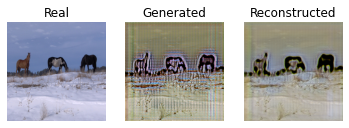

In [43]:
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

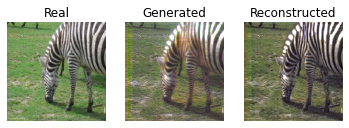

In [45]:
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)